In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pyproj
import pygmt
import eqs_magnetics as eqs
import harmonica as hm
import itertools
import xarray as xr
import synthetics
import warnings

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Load Data

In [3]:
icegrav = pd.read_csv('../data/icegrav.csv', header=0)
icegrav_synthetic = pd.read_csv('../data/icegrav_synthetic.csv', header=0)
icegrav_synthetic_sources = pd.read_csv('../data/icegrav_synthetic_sources.csv', header=0)

coordinates = [icegrav.x, icegrav.y, icegrav.Height_WGS1984]
source_coordinates = [icegrav_synthetic_sources.x, icegrav_synthetic_sources.y, icegrav_synthetic_sources.u]
dipole_moments = [icegrav_synthetic_sources.dipole_moment_x, icegrav_synthetic_sources.dipole_moment_y, icegrav_synthetic_sources.dipole_moment_u]

field_direction = np.array([hm.magnetic_angles_to_vec(1, -65, 25)]).T

In [4]:
icegrav

,Flight_ID,Line_Number,Lon,Lat,x,y,Height_WGS1984,Date,Time,MagR,...,MagRTC,BCorr_FD83,BCorr_Halley,BCorr_Applied,MagBRTC,ACorr,SCorr,MagF,MagL,MagML
0,15.0,100.0,17.666285,-83.314112,2.225511e+06,2.708058e+06,2689.4,2013/01/26,08:42:20.00,50618.44,...,320.24,197.74,-28.68,197.74,122.50,NaN,NaN,NaN,69.84,54.09
1,15.0,100.0,17.661398,-83.314174,2.225449e+06,2.708070e+06,2689.5,2013/01/26,08:42:21.00,50617.95,...,320.08,197.71,-28.68,197.71,122.37,52.63,NaN,69.74,69.73,54.03
2,15.0,100.0,17.656513,-83.314235,2.225386e+06,2.708083e+06,2689.6,2013/01/26,08:42:22.00,50617.64,...,320.00,197.68,-28.69,197.68,122.32,52.64,NaN,69.69,69.60,53.96
3,15.0,100.0,17.651631,-83.314296,2.225324e+06,2.708096e+06,2689.8,2013/01/26,08:42:23.00,50617.10,...,319.72,197.64,-28.69,197.64,122.08,52.65,NaN,69.43,69.48,53.87
4,15.0,100.0,17.646752,-83.314355,2.225261e+06,2.708109e+06,2689.9,2013/01/26,08:42:24.00,50616.83,...,319.60,197.60,-28.70,197.60,122.00,52.66,NaN,69.34,69.34,53.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404358,10.0,10480.0,-27.993470,-78.733044,1.411041e+06,3.107976e+06,1589.9,2013/01/17,12:11:37.00,45832.18,...,109.35,NaN,-29.12,-29.12,138.46,27.87,NaN,110.59,88.93,NaN
404359,10.0,10480.0,-27.994831,-78.733557,1.411041e+06,3.107911e+06,1588.7,2013/01/17,12:11:38.00,45832.61,...,109.33,NaN,-29.12,-29.12,138.45,27.94,NaN,110.51,88.93,NaN
404360,10.0,10480.0,-27.996154,-78.734072,1.411043e+06,3.107846e+06,1587.2,2013/01/17,12:11:39.00,45832.81,...,109.15,NaN,-29.12,-29.12,138.27,28.01,NaN,110.26,88.93,NaN
404361,10.0,10480.0,-27.997440,-78.734590,1.411045e+06,3.107782e+06,1585.4,2013/01/17,12:11:40.00,45833.40,...,109.24,NaN,-29.13,-29.13,138.37,28.07,NaN,110.29,88.92,NaN


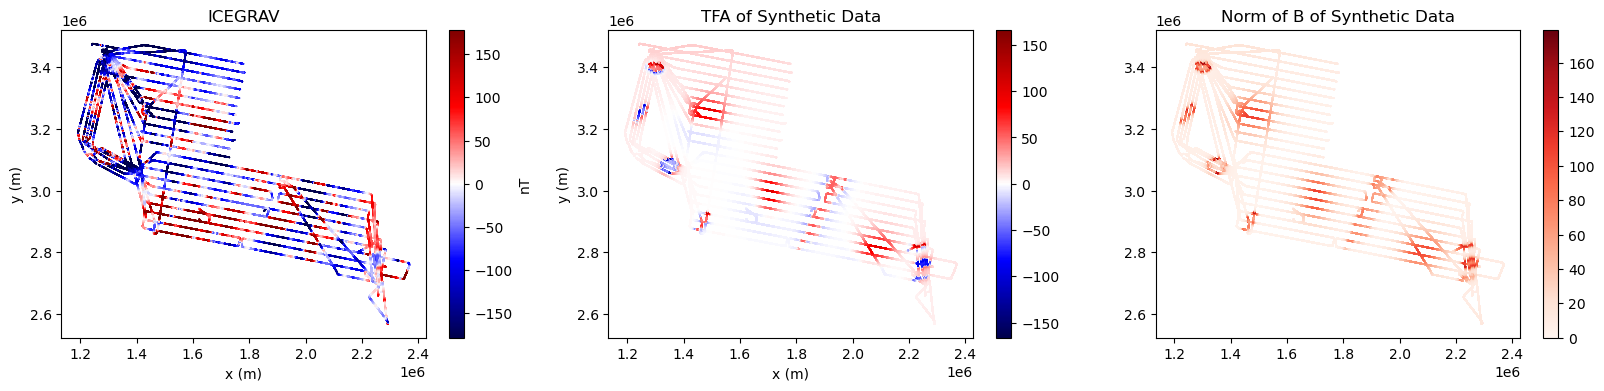

In [5]:
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
scale = np.nanpercentile(icegrav.MagL, 95)
plt.scatter(*coordinates[:2], c=icegrav.MagL, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.title("ICEGRAV")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar(label="nT")
plt.subplot(1,3,2)
scale = vd.maxabs(icegrav_synthetic.tfa)
plt.scatter(*coordinates[:2], c=icegrav_synthetic.tfa, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar()
plt.subplot(1,3,3)
scale = vd.maxabs(icegrav_synthetic.bnorm)
plt.scatter(*coordinates[:2], c=icegrav_synthetic.bnorm, cmap="Reds",s=0.01, vmin=0, vmax=scale)
plt.title("Norm of B of Synthetic Data")
plt.colorbar()
plt.show()

In [6]:
grid_spacing = 5e3
grid_coordinates = vd.grid_coordinates(vd.get_region(coordinates), spacing=grid_spacing, extra_coords=3e3)
mask = vd.distance_mask(data_coordinates=coordinates, maxdist=4.5e4, coordinates=grid_coordinates)
# mask = vd.convexhull_mask(coordinates, grid_coordinates)
grid_coords_masked = (
    np.array((xr.DataArray(grid_coordinates[0])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[1])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[2])).where(mask, drop=False))
)
true_b = eqs.dipole_magnetic(grid_coords_masked, source_coordinates, dipole_moments)
true_tfa = eqs.total_field_anomaly(true_b, field_direction)
true_bnorm = np.sqrt(sum(c**2 for c in true_b))

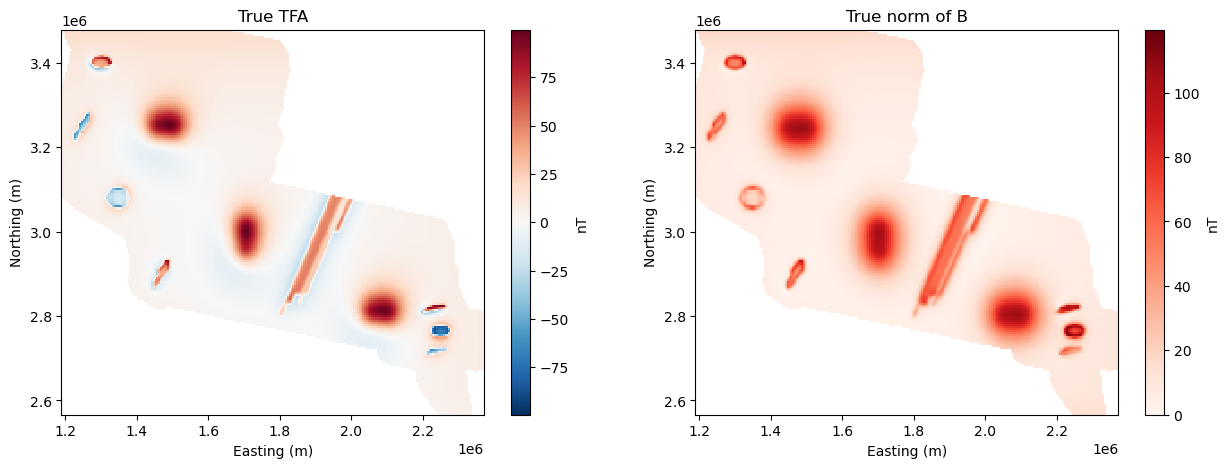

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
scale = vd.maxabs(true_tfa)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.subplot(1,2,2)
scale = vd.maxabs(true_bnorm)
plt.pcolormesh(*grid_coordinates[:2], true_bnorm, cmap="Reds", vmin=0, vmax=scale)
plt.title("True norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

## Fit deep sources

In [8]:
region = vd.get_region(coordinates)
spacing = 5e4
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing, region=(vd.pad_region(region, pad=spacing*0.5)), drop_coords=False)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=icegrav_synthetic.tfa)

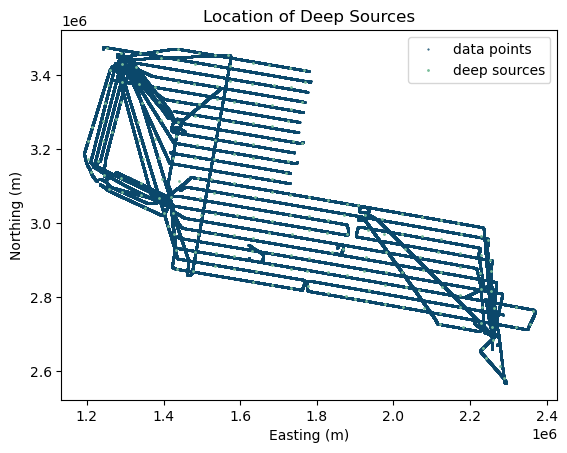

In [9]:
plt.figure()
plt.plot(*coordinates[:2], ".", color="#0B486B", markersize=1, label='data points')
plt.plot(*coords_blocked[:2], ".", color="#79BD9A", markersize=2, label='deep sources')
plt.title("Location of Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()
plt.show()

In [10]:
spacing = np.mean(vd.median_distance(coords_blocked))
# depths_deep_eqs = [spacing*2.5, spacing*3, spacing*3.5, spacing*4, spacing*4.25, spacing*4.5, spacing*5, spacing*5.5, spacing*6]
# dampings_deep_eqs = [1e-2, 1e-1, 1, 1e1, 1e2]
depths_deep_eqs = [spacing*3]
dampings_deep_eqs = [1e1]

In [11]:
parameter_sets_deep_eqs = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_deep_eqs, depths_deep_eqs)
]
print("Number of combinations:", len(parameter_sets_deep_eqs))

Number of combinations: 1


In [12]:
%%time
kfold = vd.BlockKFold(
    spacing=2500,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coords_blocked[:2])
scores = []
damping = []
source_depth = []
for parameters in parameter_sets_deep_eqs:    
    print(parameters)
    eqs_deep = eqs.EquivalentSourcesMagnetic(**parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_deep.fit(
            [c[train] for c in coords_blocked], 
            tfa_blocked[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_deep.predict([c[test] for c in coords_blocked]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_blocked[test] - predicted))
    scores.append(np.mean(tmp))
    damping.append(parameters['damping'])
    source_depth.append(parameters['depth'])

best_deep = np.argmin(scores)
parameter_sets_deep_eqs[best_deep]

{'damping': 10.0, 'depth': 110135.58980217241}
CPU times: user 11.4 s, sys: 4.69 s, total: 16.1 s
Wall time: 730 ms


{'damping': 10.0, 'depth': 110135.58980217241}

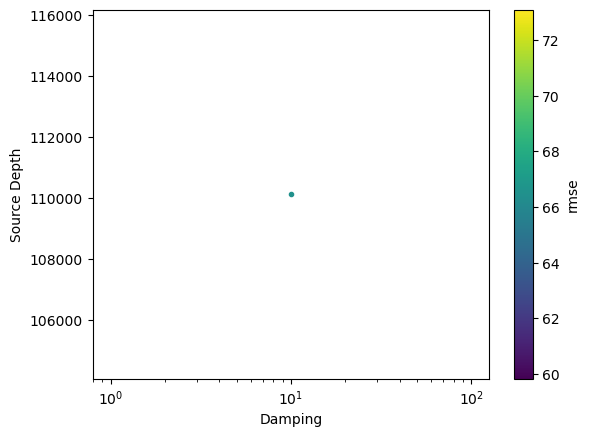

In [13]:
plt.figure()
plt.scatter(
    damping,
    source_depth,
    c=scores,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores,40),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')
plt.show()

In [14]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(**parameter_sets_deep_eqs[best_deep])
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

source height: -107251.43980217242
CPU times: user 737 ms, sys: 34.9 ms, total: 772 ms
Wall time: 23.6 ms


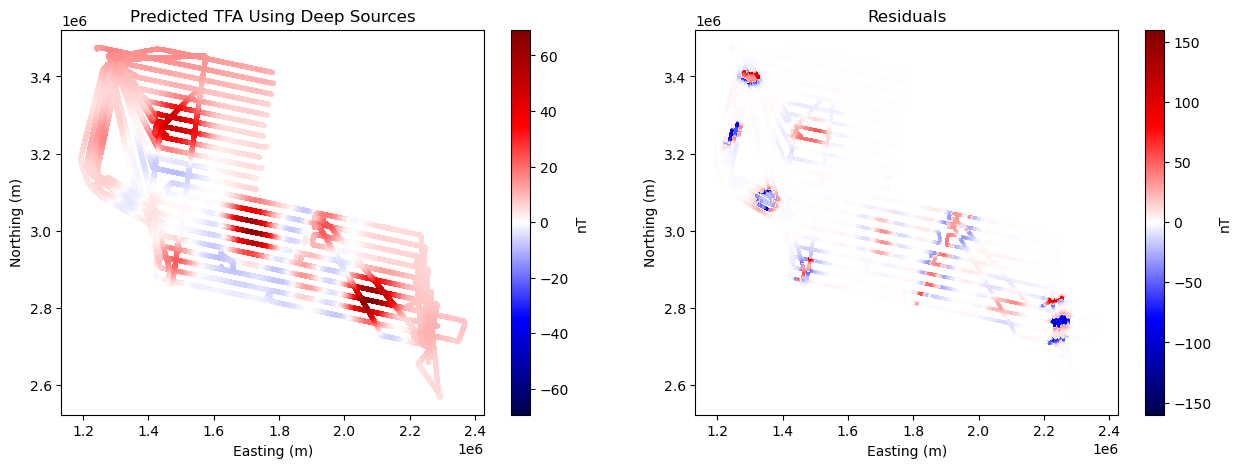

In [15]:
tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = icegrav_synthetic.tfa - tfa_deep

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
scale = vd.maxabs(tfa_deep)
plt.scatter(*coordinates[:2], c=tfa_deep, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
scale = vd.maxabs(tfa_residuals)
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

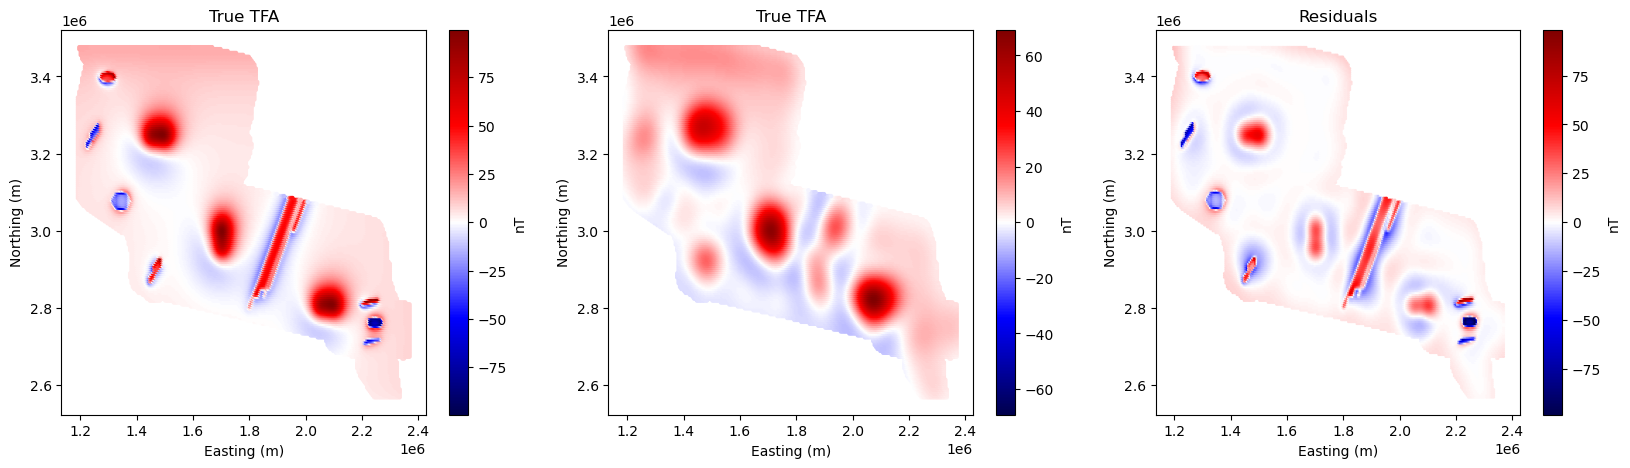

In [16]:
tfa_deep_grid = eqs.total_field_anomaly(eqs_deep.predict(grid_coords_masked), field_direction)
tfa_residuals_grid = true_tfa- tfa_deep_grid
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
scale = vd.maxabs(true_tfa)
plt.scatter(*grid_coords_masked[:2], c=true_tfa, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.subplot(1,3,2)
scale = vd.maxabs(tfa_deep_grid)
plt.scatter(*grid_coords_masked[:2], c=tfa_deep_grid, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.subplot(1,3,3)
scale = vd.maxabs(tfa_residuals_grid)
plt.scatter(*grid_coords_masked[:2], c=tfa_residuals_grid, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit the deep residuals with gradient-boosted sources

In [17]:
window_sizes = [5e3, 6e3, 9e3, 1e4]

In [18]:
%%time
kfold = vd.BlockKFold(
    spacing=1e5,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores = []
window = []
for i in window_sizes:    
    print(i)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=5e3, window_size=i, damping=1e5, depth=27e3)
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_residuals[test] - predicted))
    #print(tmp)
    scores.append(np.mean(tmp))
    window.append(i)

best_window_size = np.argmin(scores)
print(window_sizes[best_window_size])

5000.0
6000.0
9000.0
10000.0
5000.0
CPU times: user 8h 11min 25s, sys: 30.3 s, total: 8h 11min 56s
Wall time: 14min 7s


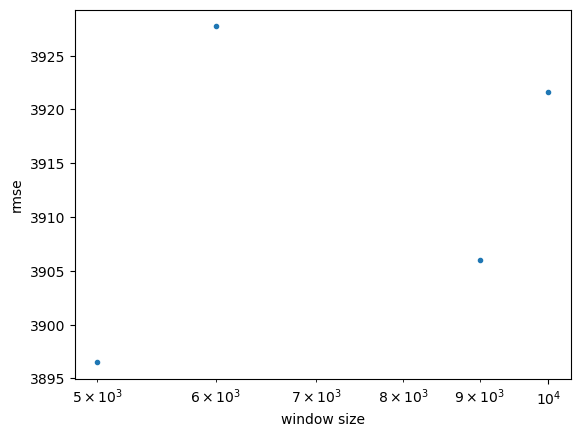

In [19]:
plt.figure()
plt.plot(window, scores, '.')
plt.xlabel('window size')
plt.ylabel('rmse')
plt.xscale('log')
plt.show()

In [20]:
dampings_shallow_eqs = [1e1, 1e2, 1e3, 1e4, 1e5]
depths_shallow_eqs = [25e3, 26e3, 27e3, 28e3, 29e3]

parameter_sets_shallow_eqs = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_shallow_eqs, depths_shallow_eqs)
]
print("Number of combinations:", len(parameter_sets_shallow_eqs))

Number of combinations: 42


In [21]:
%%time
kfold = vd.BlockKFold(
    spacing=1e5,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores = []
damping = []
source_depth = []
for parameters in parameter_sets_shallow_eqs:    
    print(parameters)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=grid_spacing, window_size=window_sizes[best_window_size], **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_residuals[test] - predicted))
    scores.append(np.mean(tmp))
    damping.append(parameters['damping'])
    source_depth.append(parameters['depth'])
best_shallow = np.argmin(scores)
parameter_sets_shallow_eqs[best_shallow]

{'damping': 0.1, 'depth': 25000.0}
{'damping': 0.1, 'depth': 26000.0}
{'damping': 0.1, 'depth': 27000.0}
{'damping': 0.1, 'depth': 28000.0}
{'damping': 0.1, 'depth': 29000.0}
{'damping': 0.1, 'depth': 30000.0}
{'damping': 0, 'depth': 25000.0}
{'damping': 0, 'depth': 26000.0}
{'damping': 0, 'depth': 27000.0}
{'damping': 0, 'depth': 28000.0}
{'damping': 0, 'depth': 29000.0}
{'damping': 0, 'depth': 30000.0}
{'damping': 10.0, 'depth': 25000.0}
{'damping': 10.0, 'depth': 26000.0}


KeyboardInterrupt: 

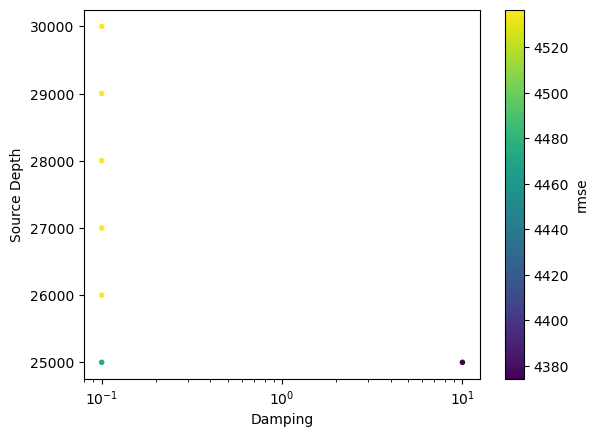

In [25]:
plt.figure()
plt.scatter(
    damping,
    source_depth,
    c=scores,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores,40),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')
plt.show()

In [23]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(
    random_state=0,
    block_size=grid_spacing,
    window_size=window_sizes[best_window_size],
    **parameter_sets_shallow_eqs[best_shallow],
    repeat=2,
)
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)
print("dipole height:", np.min(eqs_shallow.dipole_coordinates_[2]), "-", np.max(eqs_shallow.dipole_coordinates_[2]))
print("window size:", eqs_shallow.window_size_)

NameError: name 'best_shallow' is not defined

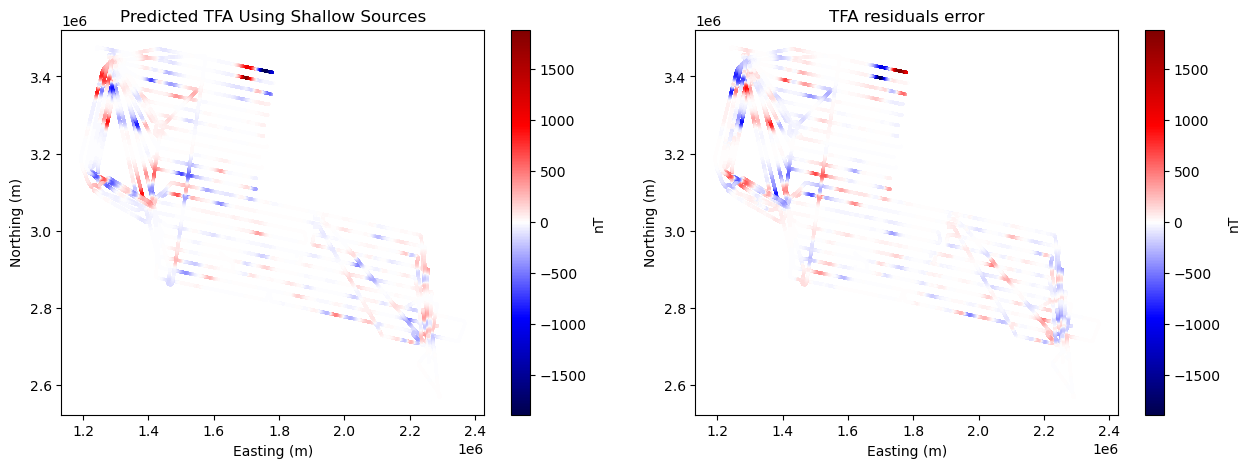

In [24]:
tfa_residuals_prediction = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(15,5))
scale = vd.maxabs(tfa_residuals_prediction)
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_residuals_prediction, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
scale = vd.maxabs(tfa_residuals - tfa_residuals_prediction)
plt.scatter(*coordinates[:2], c=tfa_residuals - tfa_residuals_prediction, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("TFA residuals error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Predict on a regular grid

In [25]:
predicted_b = eqs_deep.predict(grid_coords_masked) + eqs_shallow.predict(grid_coords_masked)
predicted_tfa = eqs.total_field_anomaly(predicted_b, field_direction)
error_tfa = true_tfa - predicted_tfa
rmse_tfa = np.sqrt(np.square(~np.isnan(error_tfa)).mean())

predicted_bnorm = np.sqrt(sum(c**2 for c in predicted_b))
error_bnorm = true_bnorm - predicted_bnorm
rmse_bnorm = np.sqrt(np.square(~np.isnan(error_bnorm)).mean())

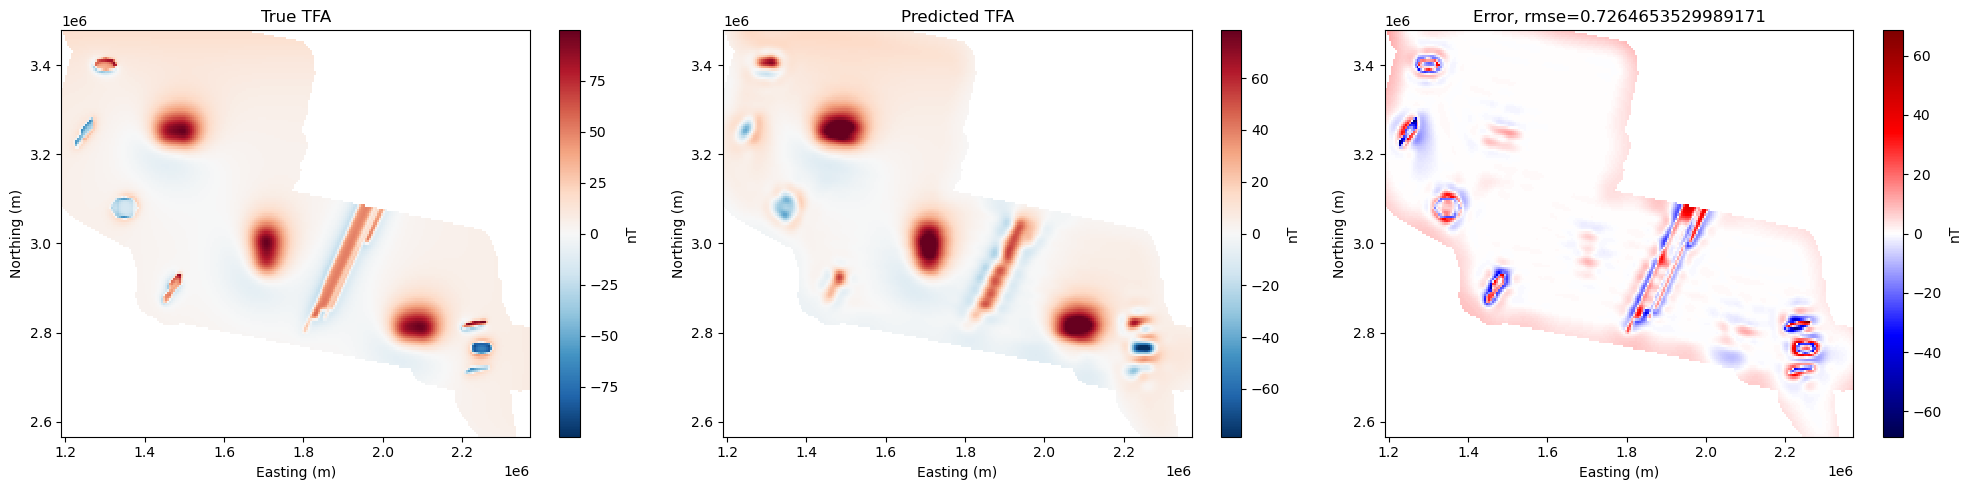

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
scale = vd.maxabs(true_tfa)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
scale = np.nanpercentile(predicted_tfa, 99)
plt.pcolormesh(*grid_coordinates[:2], predicted_tfa, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.title("Predicted TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
scale = vd.maxabs(error_tfa)
plt.pcolormesh(*grid_coordinates[:2], error_tfa, cmap="seismic", vmin=-scale, vmax=scale)
# plt.plot(*coordinates[:2], ".", color="#79BD9A", markersize=0.004, label='deep sources')
plt.title('Error, rmse={}'.format(rmse_tfa))
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

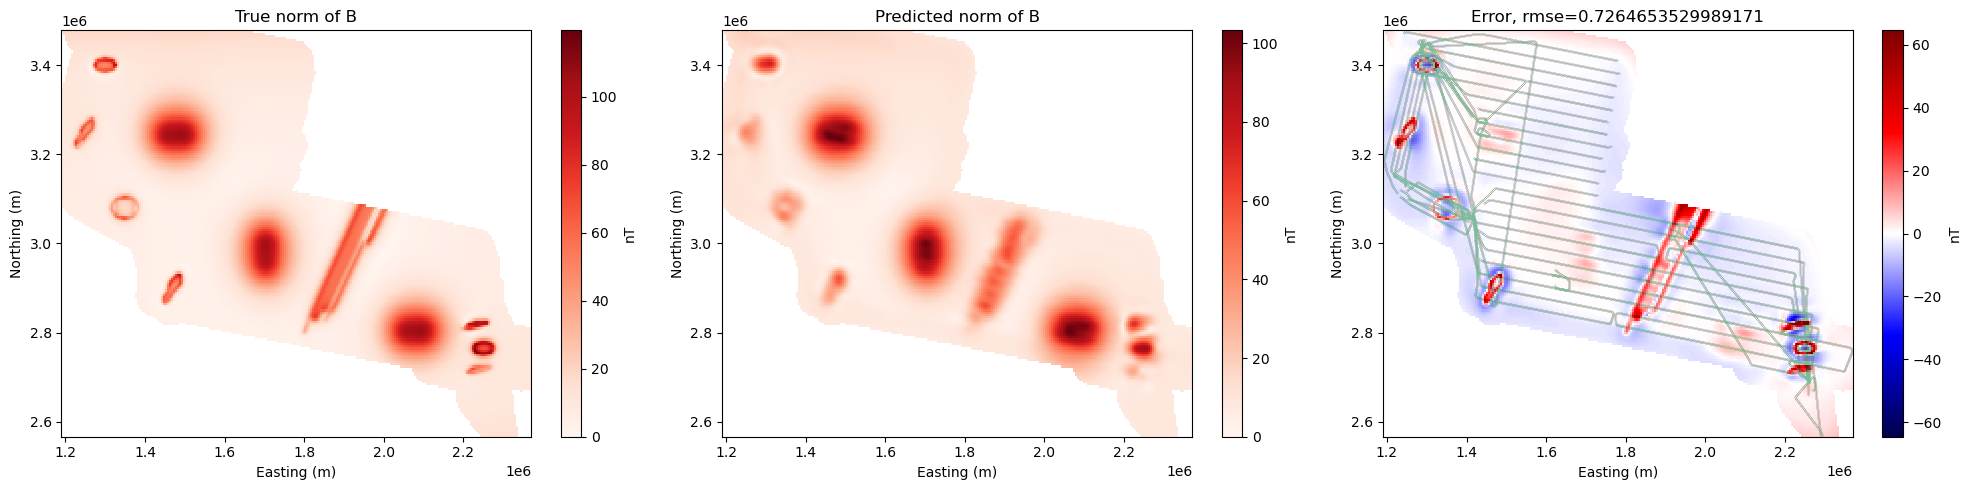

In [27]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
scale = vd.maxabs(true_bnorm)
plt.pcolormesh(*grid_coordinates[:2], true_bnorm, cmap="Reds", vmin=0, vmax=scale)
plt.title("True norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
scale = vd.maxabs(predicted_bnorm)
plt.pcolormesh(*grid_coordinates[:2], predicted_bnorm, cmap="Reds", vmin=0, vmax=scale)
plt.title("Predicted norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
scale = vd.maxabs(error_bnorm)
plt.pcolormesh(*grid_coordinates[:2], error_bnorm, cmap="seismic", vmin=-scale, vmax=scale)
plt.plot(*coordinates[:2], ".", color="#79BD9A", markersize=0.004, label='deep sources')
plt.title('Error, rmse={}'.format(rmse_bnorm))
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()